# Guía 5 - Filtros

## Ejercicio 1

Diseñe un filtro FIR mediante el método de ventanas (implementado por usted mismo), que permita eliminar el ruido de línea en una señal que fue muestreada a 300 Hz. Compare los resultados obtenidos con diferentes ventanas de truncado y diferentes cantidades de muestras en la respuesta al impulso.

### Solución

Para crear un filtro FIR, debemos seguir los pasos:
1. Definir frecuencias que se desea eliminar: pasa bajo $[0,f]$, pasa alto $[f,f_m]$, pasa banda $[f_1,f_2]$, rechaza banda $[0,f_1)(f_2,f_m]$
2. Antitransformar
3. Aplicar ventana de N muestras (cualquiera)
4. Aplicar desplazamiento de $\frac{N-1}{2}$ muestras. Para esto utilizar la propiedad de retardo de la TDF
$$x[n-i] \xLeftrightarrow{\mathcal{F}} X[k]e^{-j\omega i}$$
Obviamente vamos a aplicarlo antes de antitransformar, pero se menciona aca para que se entienda el por qué.

5. Obtener respuesta al impulso

/home/lucas/.local/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/lucas/.local/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


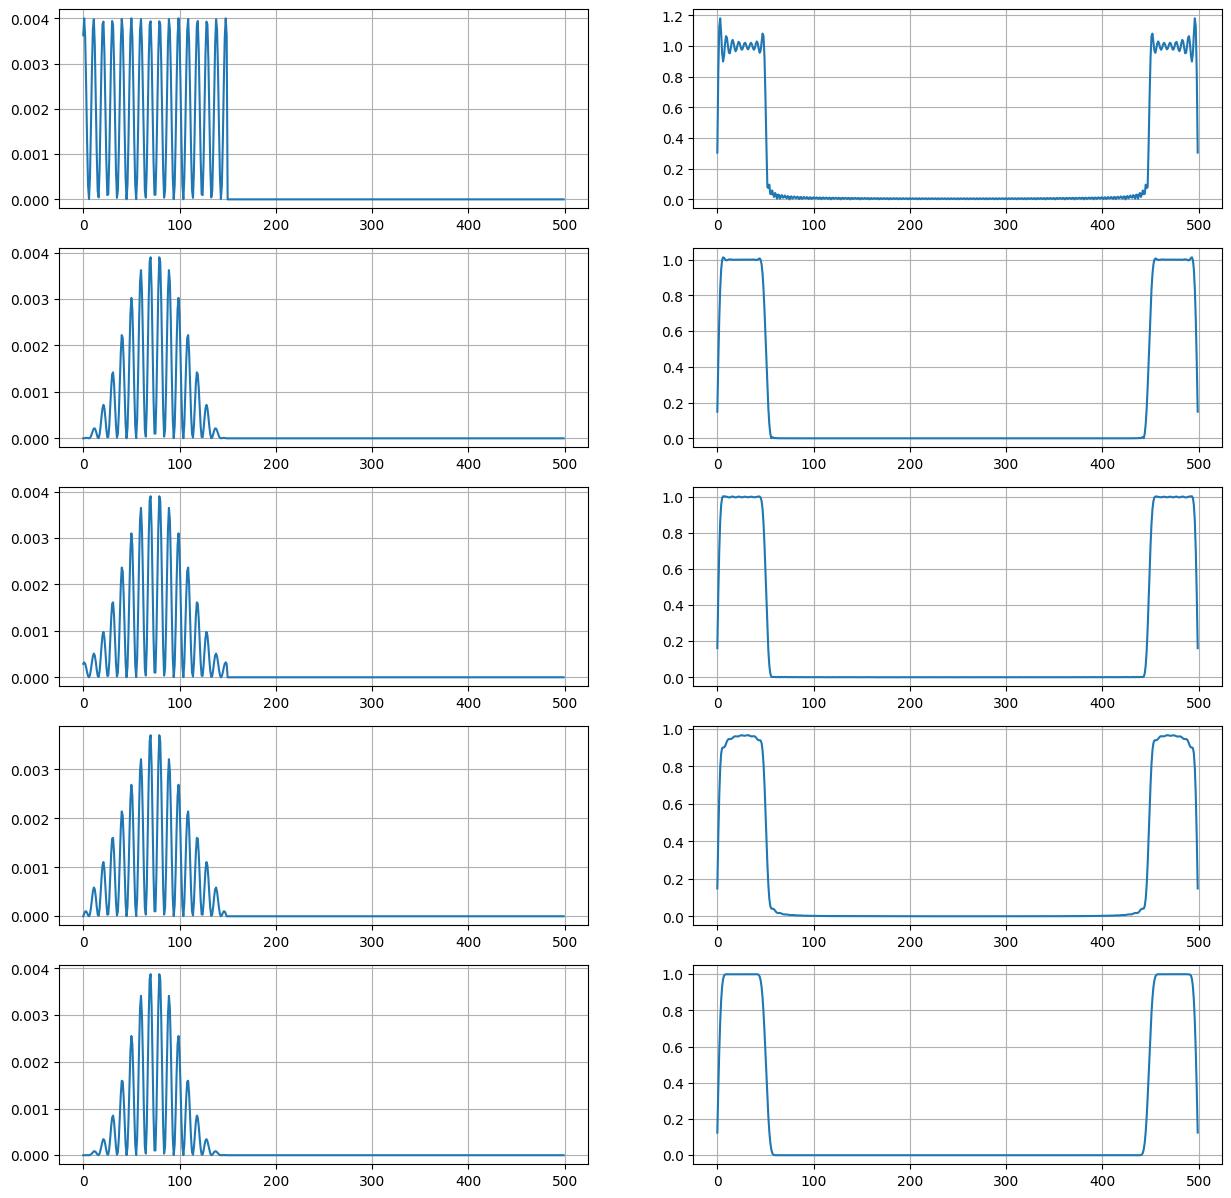

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def rectangular(s,Nini,Nfin):
    '''Ventana rectangular aplicada a s entre las muestras Nini y Nfin'''
    w = np.ones(Nfin-Nini)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def hann(s,Nini,Nfin):
    '''Ventana de Hann aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2*np.pi/N
    w = [0.5 for _ in range(N)] - 0.5 * np.cos(aux*n)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)
    

def hamming(s,Nini,Nfin):
    '''Ventana de Hamming aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2*np.pi/N
    w = [27/50 for _ in range(N)] - 23/50 * np.cos(aux*n)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def bartlett(s,Nini,Nfin):
    '''Ventana de Bartlett aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2.0/N
    w = np.where(np.less_equal(n,N/2.0),n*aux,[2 for _ in range(N)] - n*aux)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def blackman(s,Nini,Nfin):
    '''Ventana de Blackman aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2*np.pi/N
    w = [21/50 for _ in range(N)] - 0.5*np.cos(aux*n) + (2/25)*np.cos(2*aux*n)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def pasabajoFreq(fm,f):
    '''genera el espectro de frecuencias "ideal" para un filtro pasabajo de frecuencia muestreal fm para frecuencias <= f. "sobremuestreado" x10'''
    return np.concatenate([
        np.ones(f*10 + 1),
        np.zeros(fm*10-2*(f*10 + 1)),
        np.ones(f*10 + 1),
    ])

def retardar(X,t_0):
    N = len(X)
    Xret = np.zeros(N, dtype=complex)
    aux = -1j*2*np.pi*t_0/N
    for k in range(N):
        Xret[k] = X[k]*np.exp(aux*k)
    return Xret

def FIRPasaBajo(fm,f,N, W):
    '''Genera un h[n] de un filtro pasa bajo para frecuencias <= f, con duracion N muestras y aplicando la ventana W'''

    # Generar espectro de frecuencias deseado
    X = pasabajoFreq(fm,f)

    # Aplicar retraso
    X = retardar(X,(N*10-1)/2)

    # Antitransformar
    x = np.fft.ifft(X)

    # Aplicar ventana
    x = W(x,0,N*10)

    return x

hrectangular = FIRPasaBajo(50,5,15,rectangular)
hhann = FIRPasaBajo(50,5,15,hann)
hhamming = FIRPasaBajo(50,5,15,hamming)
hbartlett = FIRPasaBajo(50,5,15,bartlett)
hblackman = FIRPasaBajo(50,5,15,blackman)

fig, ax = plt.subplots(5,2)
fig.set_figheight(15)
fig.set_figwidth(15)
for axi in ax:
    for axj in axi:
        axj.grid()

ax[0][0].plot(hrectangular)
ax[1][0].plot(hhann)
ax[2][0].plot(hhamming)
ax[3][0].plot(hbartlett)
ax[4][0].plot(hblackman)

ax[0][1].plot(np.abs(np.fft.fft(hrectangular)))
ax[1][1].plot(np.abs(np.fft.fft(hhann)))
ax[2][1].plot(np.abs(np.fft.fft(hhamming)))
ax[3][1].plot(np.abs(np.fft.fft(hbartlett)))
ax[4][1].plot(np.abs(np.fft.fft(hblackman)))